## Data Cleaning Goals
1. I want to create data that will allow me to
   
   a. analyze the structure of hierarchy across GitHub Repositories (whose opening issues? whose commenting on issues? how many are there overall?)
   
   b. track the sequence of participation for each issue
   
   c. link PRs to issues
   
   d. collect covariates related to issues so I can measure "issue difficulty"
   

In [1]:
from IPython.display import display, HTML

def pretty_print(df):
    return display(HTML(df.to_html().replace("\\n","<br>") ) )

In [2]:
## Import Libraries and Data

In [3]:
import glob
import dask.dataframe as dd
import pandas as pd
from pandarallel import pandarallel
import matplotlib.pyplot as plt
from datetime import timezone
import datetime
import ast
import numpy as np
from operator import itemgetter
from stargazer.stargazer import Stargazer

In [4]:
plt.style.use("seaborn")

In [8]:
pandarallel.initialize(progress_bar = True)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [9]:
pd.set_option('display.max_columns', None)

In [10]:
%%time
# Read data on issue comments, issues
issue_com = glob.glob('data/github_clean/filtered_github_data/issueCo*')
issue_com.extend(glob.glob('data/github_clean/github_data_pre_18/issueCo*'))
df_issue_comments = pd.concat([pd.read_csv(ele, index_col = 0) for ele in issue_com]).reset_index(drop = True)

issues = glob.glob('data/github_clean/filtered_github_data/issues*')
issues.extend(glob.glob('data/github_clean/github_data_pre_18/issues*'))
df_issue = pd.concat([pd.read_csv(ele, index_col = 0) for ele in issues]).reset_index(drop = True)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

## Storing Data

In [8]:
OriginalDataStatistics = pd.DataFrame()
DataDescriptives = pd.DataFrame()

## Data Cleaning

In [9]:
# columns to rename
mod_columns = [ele for ele in df_issue_comments.columns if 'latest' in ele]
mod_dict = {ele : ele.replace('latest_', '') for ele in mod_columns}
df_issue_comments.rename(mod_dict, axis = 1, inplace = True)

In [10]:
full_issue_data = pd.concat([df_issue,df_issue_comments])

In [11]:
# clean data: remove entries with NA issue number values  
df_issue_clean = full_issue_data[~full_issue_data['issue_number'].isna()]
# clean data: add key variable
df_issue_clean['key'] = df_issue_clean['repo_id'].apply(str) + "_" + df_issue_clean['issue_number'].apply(str)

/tmp/user/20506/ipykernel_1998686/1104531115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_issue_clean['key'] = df_issue_clean['repo_id'].apply(str) + "_" + df_issue_clean['issue_number'].apply(str)


In [12]:
df_issue_clean['created_at'] = pd.to_datetime(df_issue_clean['created_at'])
df_issue_clean['created_at'] = df_issue_clean['created_at'].dt.tz_localize(None)

/tmp/user/20506/ipykernel_1998686/3002124751.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_issue_clean['created_at'] = pd.to_datetime(df_issue_clean['created_at'])
/tmp/user/20506/ipykernel_1998686/3002124751.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_issue_clean['created_at'] = df_issue_clean['created_at'].dt.tz_localize(None)


In [13]:
# FIX people who aren't classified as owner
fix_ind = df_issue_clean[df_issue_clean.parallel_apply(lambda x: x['repo_name'].split("/")[0] == x['issue_user_login'], axis = 1)].index
df_issue_clean.loc[fix_ind, 'issue_author_association'] = 'OWNER'

fix_ind_actor = df_issue_clean[df_issue_clean.parallel_apply(lambda x: x['repo_name'].split("/")[0] == x['actor_login'], axis = 1)].index
df_issue_clean.loc[fix_ind_actor, 'actor_repo_association'] = 'OWNER'

In [14]:
df_actor_missing = df_issue_clean[['actor_repo_association', 'actor_login', 'key']].drop_duplicates()
df_actor_missing['count'] = df_actor_missing.groupby(['actor_login','key']).transform('count')

In [15]:
df_actor_missing

,actor_repo_association,actor_login,key,count
0,OWNER,tkalus,96523010_197.0,2
1,NaN,pyup-bot,54683816_1.0,0
2,NaN,Murukarthick,97612481_440.0,1
3,OWNER,DeniRibicic,97612481_736.0,1
4,NaN,lorena1976,33614304_1192.0,0
...,...,...,...,...
3966532,COLLABORATOR,cycleuser,62860862_5.0,1
3966534,NONE,coveralls,101275731_20.0,1
3966537,COLLABORATOR,markotoplak,53335377_182.0,1
3966539,NaN,dwt,1372698_2.0,0


In [16]:
# issue_author_association - author association for individual who opened the issue
# actor_repo_association - author association for individual associated with repository
# need to add actor_repo_association for IssuesEvent
# for "opened" action, just fill in with issue_author_association
opened_issues = df_issue_clean[(df_issue_clean['type'] == 'IssuesEvent') & (df_issue_clean['issue_action'] == 'opened')].index
df_issue_clean.loc[opened_issues, 'actor_repo_association'] = df_issue_clean.loc[opened_issues, 'issue_author_association']
# for "closed" action, need to impute - create table of ranks throughout time

In [12]:
all_ranks = df_issue_clean[((df_issue_clean['type'] == 'IssuesEvent') & (df_issue_clean['issue_action'] == 'opened')) | 
    (df_issue_clean['type'] == 'IssueCommentEvent')][[
    'actor_login', 'created_at', 'actor_repo_association', 'repo_name']].drop_duplicates().sort_values(
    ['actor_login', 'repo_name', 'created_at']).dropna().reset_index(drop = True)

In [13]:
all_ranks = all_ranks.sort_values(['actor_login', 'repo_name', 'created_at'])

In [14]:
all_ranks_change = all_ranks.groupby(['actor_login', 'repo_name', 'actor_repo_association'])['created_at'].min().reset_index()

In [15]:
all_ranks_change['min_date'] = all_ranks_change.groupby(['actor_login', 'repo_name'])['created_at'].transform('min')
all_ranks_change['max_date'] = all_ranks_change.groupby(['actor_login', 'repo_name'])['created_at'].transform('max')

In [16]:
all_ranks_change['count'] = all_ranks_change.sort_values('created_at').groupby(['actor_login', 'repo_name']).cumcount()+1
all_ranks_change['max_count'] = all_ranks_change.sort_values('created_at').groupby(['actor_login', 'repo_name']).transform('count')['count']

In [17]:
# remove people who suddenly become NONE after being ranked
all_ranks_change = all_ranks_change[~all_ranks_change.apply(lambda x: x['actor_repo_association'] == 'NONE' and x['count']>1 and x['count']<=x['max_count'],
                                       axis = 1)]

In [18]:
all_ranks_change = all_ranks_change.sort_values(
    by = ['actor_login', 'repo_name','created_at'])

In [19]:
all_ranks_change['interval_end'] = all_ranks_change.sort_values(
    by = ['created_at']).groupby(
    ['actor_login', 'repo_name'], sort = True)['created_at'].shift(-1)

In [20]:
all_ranks_change.loc[all_ranks_change[all_ranks_change['interval_end'].isna()].index,'interval_end'] = datetime(2023, 8, 31, 11, 59, 59)

In [21]:
## some people are owners when they should not be...
# remove if they're an owner when they're not supposed to be... 
all_ranks_change = all_ranks_change[(all_ranks_change['actor_repo_association'] != 'OWNER') |
    (all_ranks_change.apply(lambda x: x['actor_login'] == x['repo_name'].split("/")[0], axis = 1))]

In [22]:
all_ranks_change['interval_actor'] = all_ranks_change.apply(
    lambda x: [x['actor_repo_association'], x['created_at'], x['interval_end']], axis = 1)
grouped_rank = all_ranks_change.sort_values(['actor_login', 'repo_name', 'created_at']).groupby(
    ['actor_login', 'repo_name', 'min_date', 'max_date']).agg({'interval_actor':list}).reset_index().set_index(['actor_login', 'repo_name'])
grouped_rank['min_date'] = pd.to_datetime(grouped_rank['min_date'])
grouped_rank['max_date'] = pd.to_datetime(grouped_rank['max_date'])

In [23]:
grouped_rank = grouped_rank.reset_index()

In [24]:
grouped_rank['rank_max_date_actor'] = grouped_rank.apply(lambda x: [x['max_date'], x['interval_actor'][-1][0]], axis = 1)
grouped_rank['rank_min_date_actor'] = grouped_rank.apply(
    lambda x: [x['max_date'], 'NONE'] if x['actor_login'] != x['repo_name'].split("/")[0] else [x['max_date'], 'OWNER'], axis = 1)
grouped_rank['rank_max_date_issue'] = grouped_rank['rank_max_date_actor']
grouped_rank['rank_min_date_issue'] = grouped_rank['rank_min_date_actor']
grouped_rank['interval_issue'] = grouped_rank['interval_actor']

In [30]:
df_issue_clean = pd.merge(df_issue_clean, grouped_rank[['actor_login', 'repo_name', 'rank_max_date_actor', 'rank_min_date_actor', 'interval_actor']],
                          how = 'left', on = ['actor_login', 'repo_name'])

df_issue_clean = pd.merge(df_issue_clean, grouped_rank[['actor_login', 'repo_name', 'rank_max_date_issue', 'rank_min_date_issue', 'interval_issue']].rename({
    'actor_login':'issue_user_login'}, axis = 1),
                          how = 'left', on = ['issue_user_login', 'repo_name'])

In [31]:
"""df_issue_clean = df_issue_clean.drop(['rank_max_date_x','rank_min_date_x','interval_x'], axis = 1).rename({
    'rank_max_date_y':'rank_max_date',
    'rank_min_date_y':'rank_min_date',
    'interval_y':'interval'}, axis = 1)"""

"df_issue_clean = df_issue_clean.drop(['rank_max_date_x','rank_min_date_x','interval_x'], axis = 1).rename({\n    'rank_max_date_y':'rank_max_date',\n    'rank_min_date_y':'rank_min_date',\n    'interval_y':'interval'}, axis = 1)"

In [32]:
df_issue_clean['actor_repo_association_repaired'] = df_issue_clean['actor_repo_association']
na_repo_association = df_issue_clean[['rank_max_date_actor', 'rank_min_date_actor', 'interval_actor']].dropna().index
na_issue_repo_association = df_issue_clean[['rank_max_date_issue', 'rank_min_date_issue', 'interval_issue']].dropna().index

In [33]:
print(df_issue_clean['actor_repo_association_repaired'].isna().mean(),
      df_issue_clean['actor_repo_association_repaired'].isna().sum())

0.24620620437992236 1246916


In [34]:
print(df_issue_clean.loc[na_repo_association,'actor_repo_association_repaired'].isna().mean(),
      df_issue_clean.loc[na_repo_association,'actor_repo_association_repaired'].isna().sum())

0.17998320522546507 829895


In [35]:
for col in ['rank_max_date_actor', 'rank_min_date_actor']:
    df_issue_clean.loc[na_repo_association, col] = df_issue_clean.loc[na_repo_association, col].apply(
        lambda x: [pd.to_datetime(x[0]), x[1]])
for col in ['rank_max_date_issue', 'rank_min_date_issue']:
    df_issue_clean.loc[na_issue_repo_association, col] = df_issue_clean.loc[na_issue_repo_association, col].apply(
        lambda x: [pd.to_datetime(x[0]), x[1]])

In [36]:
df_issue_clean.loc[na_repo_association, 'actor_repo_association_repaired'] = df_issue_clean.loc[na_repo_association].apply(
    lambda x: x['rank_min_date_actor'][1] if (x['created_at']<x['rank_min_date_actor'][0]) else 
    x['rank_max_date_actor'][1] if x['created_at']>=x['rank_max_date_actor'][0] else
    [ele[0] for ele in x['interval_actor'] if x['created_at'] >= ele[1] and x['created_at'] < ele[2]], axis = 1)
df_issue_clean.loc[na_repo_association, 'actor_repo_association_repaired'] = df_issue_clean.loc[na_repo_association, 
    'actor_repo_association_repaired'].apply(lambda x: x[0] if type(x) == list and len(x)>=1 else np.nan if type(x) == list else x)

In [37]:
df_issue_clean.to_csv('df_issue_clean_removebad.csv')

In [38]:
#df_issue_clean = pd.read_csv('df_issue_clean.csv', index_col = 0)

In [39]:
df_issue_clean['issue_author_association_repaired'] = df_issue_clean['issue_author_association'] 

In [40]:
df_issue_clean.loc[na_issue_repo_association, 'issue_author_association_repaired'] = \
    df_issue_clean.loc[na_issue_repo_association].apply(
    lambda x: x['rank_min_date_issue'][1] if (x['created_at']<x['rank_min_date_issue'][0]) else 
    x['rank_max_date_issue'][1] if x['created_at']>=x['rank_max_date_issue'][0] else
    [ele[0] for ele in x['interval_issue'] if x['created_at'] >= ele[1] and x['created_at'] < ele[2]], axis = 1)
df_issue_clean.loc[na_issue_repo_association, 'issue_author_association_repaired'] = df_issue_clean.loc[na_issue_repo_association,
    'issue_author_association_repaired'].apply(lambda x: x[0] if type(x) == list and len(x)>=1 else np.nan if type(x) == list else x)



In [41]:
print(df_issue_clean['actor_repo_association_repaired'].isna().mean(),
      df_issue_clean['actor_repo_association_repaired'].isna().sum())
print(df_issue_clean['issue_author_association_repaired'].isna().mean(),
      df_issue_clean['issue_author_association_repaired'].isna().sum())

0.08234167943688235 417021
0.12564885233918563 636351


In [42]:
print(df_issue_clean.loc[na_repo_association,'actor_repo_association_repaired'].isna().mean(),
      df_issue_clean.loc[na_repo_association,'actor_repo_association_repaired'].isna().sum())
print(df_issue_clean.loc[na_issue_repo_association,'issue_author_association_repaired'].isna().mean(),
      df_issue_clean.loc[na_issue_repo_association,'issue_author_association_repaired'].isna().sum())

0.0 0
0.0 0


In [43]:
df_issue_clean.to_csv('df_issue_clean_removebad.csv')

In [44]:
# Some Statistics on Issues
uq_issue_comments = df_issue_clean[df_issue_clean['type'] == 'IssueCommentEvent']['key'].unique().tolist()
uq_issues = df_issue_clean[df_issue_clean['type'] == 'IssuesEvent']['key'].unique().tolist()
OriginalDataStatistics.loc['Unique Issues (from comments data)', 'count'] = len(uq_issue_comments)
OriginalDataStatistics.loc['Unique Issues (from issues data)', 'count'] = len(uq_issues)
uq_issue_comments.extend(uq_issues)
uq_issue_comments = list(set(uq_issue_comments))
OriginalDataStatistics.loc['Unique Issues (from all data)']  = len(uq_issue_comments)

In [45]:
OriginalDataStatistics

,count
Unique Issues (from comments data),1136491.0
Unique Issues (from issues data),751865.0
Unique Issues (from all data),1300126.0


In [46]:
# total number of issues 
DataDescriptives.loc[0, 'Total # of Issues'] = df_issue_clean['key'].unique().shape[0]
nunique_issues = df_issue_clean.groupby('repo_name').agg({'issue_number':'nunique'})
DataDescriptives.loc[0, 'Total # of Projects'] = nunique_issues.shape[0]
DataDescriptives.loc[0, 'Average # of Issues/Project'] = nunique_issues.mean()[0]
DataDescriptives.loc[0,"Median # of Issues/Project"] = nunique_issues.median()[0]
DataDescriptives.style.set_caption("Data Descriptives")
DataDescriptives.round(2).to_markdown('descriptives/issues/aggregate_statistics.md')
DataDescriptives

,Total # of Issues,Total # of Projects,Average # of Issues/Project,Median # of Issues/Project
0,1300126.0,6453.0,201.478382,49.0


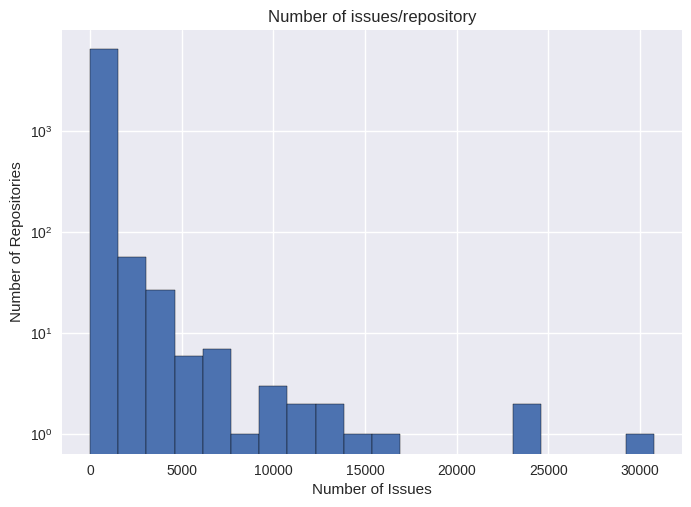

In [47]:
# PLOT ISSUE COUNT PER REPOSITORY
# Initialize layout
fig, ax = plt.subplots()
#plot
ax.hist(nunique_issues['issue_number'], bins=20, edgecolor="black")
ax.set_title('Number of issues/repository')
ax.set_xlabel('Number of Issues')
ax.set_ylabel('Number of Repositories')
ax.set_yscale('log')
plt.savefig('descriptives/issues/issue_repository.png')
plt.show()

In [48]:
# PROPORTION OF ALL ISSUES CONTAINED IN top 300 of repos with most issues
(nunique_issues/nunique_issues.sum()).sort_values('issue_number', ascending = False).head(300).sum()

issue_number    0.538143
dtype: float64

In [49]:
# LATEST STATUS FOR ISSUE
df_issue_clean['created_at'] = pd.to_datetime(df_issue_clean['created_at'])
df_issue_clean = df_issue_clean.sort_values('created_at', ascending = False)
df_issue_latest_status = df_issue_clean[~df_issue_clean.duplicated(['repo_id', 'issue_number'])]
print(df_issue_latest_status['issue_action'].rename('Issue Latest Status').value_counts(normalize = True).round(3).to_markdown())

| Issue Latest Status   |   proportion |
|:----------------------|-------------:|
| closed                |        0.824 |
| opened                |        0.172 |
| reopened              |        0.004 |


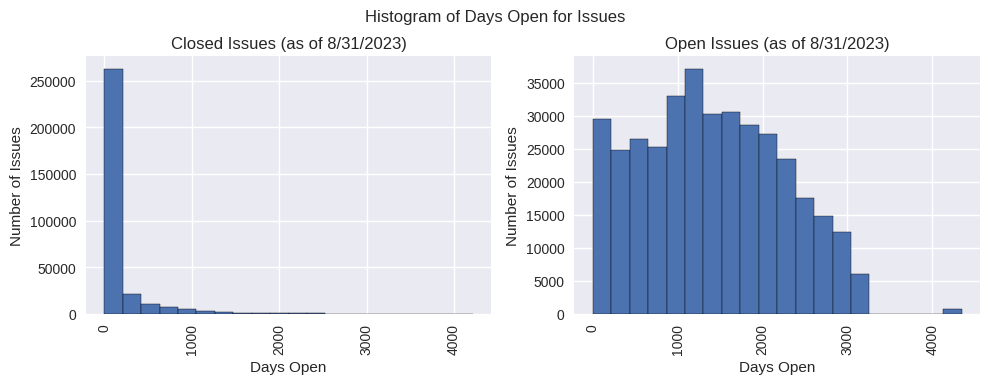

In [50]:
closed_issues = df_issue_latest_status[df_issue_latest_status['issue_action'] == 'closed']['key'].tolist()
# includes open, reopened
open_issues = df_issue_latest_status[df_issue_latest_status['issue_action'] != 'closed']['key'].tolist()

status_dates = df_issue_clean.groupby(['repo_name', 'issue_number', 'key', 'issue_action']).agg({'created_at': ['min', 'max']}).reset_index()
status_dates.columns = ['repo_name', 'issue_number', 'key', 'issue_action', 'min_date', 'max_date']
status_dates = status_dates.pivot(index = ['repo_name', 'issue_number', 'key'], columns = 'issue_action', values = ['min_date' ,'max_date']).reset_index()
status_dates.columns = ['repo_name', 'issue_number', 'key', 'closed_min_date', 'opened_min_date', 'reopened_min_date', 
                        'closed_max_date', 'opened_max_date', 'reopened_max_date']
# remove ones that do not have an opened_min_date
status_dates = status_dates[~status_dates['opened_min_date'].isna()]
# ones that are closed - time open: use earliest open date minus latest close date
closed_ind = status_dates[status_dates['key'].isin(closed_issues)].index
status_dates.loc[closed_ind, 'open_time'] = status_dates.loc[closed_ind, 'closed_max_date'] - \
    status_dates.loc[closed_ind, 'opened_min_date']
# ones that are still open - time open: use 8/31/2023 - opened date
open_ind = status_dates[status_dates['key'].isin(open_issues)].index
last_date = datetime(2023, 8, 31, 11, 59, 59)
status_dates.loc[open_ind, 'open_time'] = last_date - status_dates.loc[open_ind, 'opened_min_date']

# type of issue
status_dates.loc[closed_ind, 'status'] = 'closed'
status_dates.loc[open_ind, 'status'] = 'open'
status_dates['open_time_days'] = status_dates['open_time'].apply(lambda x: x.days)

### PLOT EXCLUDES ISSUES THAT WE DO NOT HAVE OPENED/CLOSED dates for
# Initialize layout
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
#plot
status_dates.hist('open_time_days', by = 'status', bins=20, edgecolor="black", ax = ax)
fig.suptitle('Histogram of Days Open for Issues')
for a in ax:
    a.set_ylabel('Number of Issues')
    a.set_xlabel('Days Open')
    #a.set_yscale('log')
ax[0].set_title('Closed Issues (as of 8/31/2023)')
ax[1].set_title('Open Issues (as of 8/31/2023)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [51]:
def lessThanGroups(status_dates):
    og_shape = status_dates.shape[0]
    one_day = status_dates[status_dates['open_time_days']<=1].shape[0]/og_shape
    one_week = status_dates[status_dates['open_time_days']<=7].shape[0]/og_shape
    one_month = status_dates[status_dates['open_time_days']<=30].shape[0]/og_shape
    six_month = status_dates[status_dates['open_time_days']<=180].shape[0]/og_shape
    one_year = status_dates[status_dates['open_time_days']<=365].shape[0]/og_shape
    g_one_year = status_dates[status_dates['open_time_days']>365].shape[0]/og_shape
    return [one_day, one_week, one_month, six_month, one_year, g_one_year, og_shape]

In [52]:
df_open_days = pd.DataFrame([lessThanGroups(status_dates[status_dates['status'] == 'closed']),
              lessThanGroups(status_dates[status_dates['status'] == 'open'])]).round(2)
df_open_days.index = ['closzed issues', 'open issues']
df_open_days.columns = ['open $\leq$ 1 day', 'open $\leq$ 1 week', 'open $\leq$ 1 month', 'open $\leq$ 6 months', \
                        'open $\leq$ 1 year', 'open $>$ 1 year', '# of issues']
df_open_days

,open $\leq$ 1 day,open $\leq$ 1 week,open $\leq$ 1 month,open $\leq$ 6 months,open $\leq$ 1 year,open $>$ 1 year,# of issues
closzed issues,0.31,0.46,0.61,0.82,0.89,0.11,315827
open issues,0.00,0.00,0.01,0.07,0.13,0.87,367591


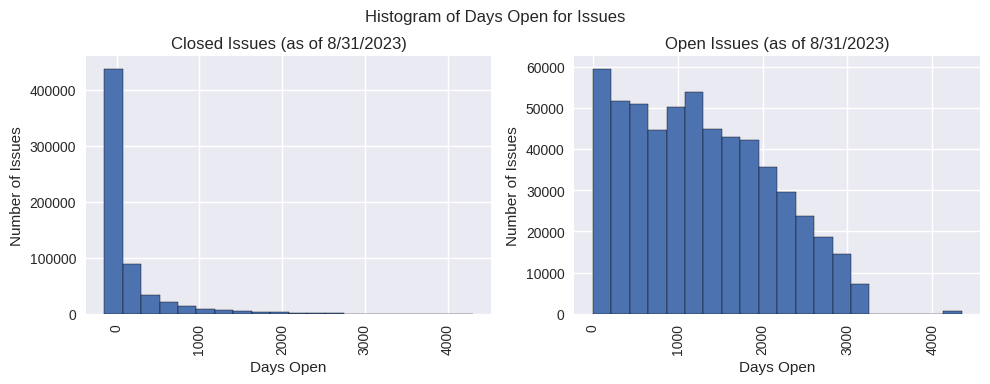

In [53]:
# TEST WHAT HAPPENS WHEN WE "APPROXIMATE" 
closed_issues = df_issue_latest_status[df_issue_latest_status['issue_state'] == 'closed']['key'].tolist()
# includes open, reopened
open_issues = df_issue_latest_status[df_issue_latest_status['issue_state'] != 'closed']['key'].tolist()

status_dates = df_issue_clean.groupby(['repo_name', 'issue_number', 'key', 'issue_state']).agg({'created_at': ['min', 'max']}).reset_index()
status_dates.columns = ['repo_name', 'issue_number', 'key', 'issue_state', 'min_date', 'max_date']
status_dates = status_dates.pivot(index = ['repo_name', 'issue_number', 'key'], columns = 'issue_state', values = ['min_date' ,'max_date']).reset_index()
status_dates.columns = ['repo_name', 'issue_number', 'key', 'closed_min_date', 'opened_min_date', 
                        'closed_max_date', 'opened_max_date']
# remove ones that do not have an opened_min_date
status_dates = status_dates[~status_dates['opened_min_date'].isna()]
# ones that are closed - time open: use earliest open date minus latest close date
closed_ind = status_dates[status_dates['key'].isin(closed_issues)].index
status_dates.loc[closed_ind, 'open_time'] = status_dates.loc[closed_ind, 'closed_max_date'] - \
    status_dates.loc[closed_ind, 'opened_min_date']
# ones that are still open - time open: use 8/31/2023 - opened date
open_ind = status_dates[status_dates['key'].isin(open_issues)].index
last_date = datetime(2023, 8, 31, 11, 59, 59)
status_dates.loc[open_ind, 'open_time'] = last_date - status_dates.loc[open_ind, 'opened_min_date']

# type of issue
status_dates.loc[closed_ind, 'status'] = 'closed'
status_dates.loc[open_ind, 'status'] = 'open'
status_dates['open_time_days'] = status_dates['open_time'].apply(lambda x: x.days)

### PLOT EXCLUDES ISSUES THAT WE DO NOT HAVE OPENED/CLOSED dates for
# Initialize layout
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
#plot
status_dates.hist('open_time_days', by = 'status', bins=20, edgecolor="black", ax = ax)
fig.suptitle('Histogram of Days Open for Issues')
for a in ax:
    a.set_ylabel('Number of Issues')
    a.set_xlabel('Days Open')
    #a.set_yscale('log')
ax[0].set_title('Closed Issues (as of 8/31/2023)')
ax[1].set_title('Open Issues (as of 8/31/2023)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [54]:
df_open_days = pd.DataFrame([lessThanGroups(status_dates[status_dates['status'] == 'closed']),
              lessThanGroups(status_dates[status_dates['status'] == 'open'])]).round(2)
df_open_days.index = ['closed issues', 'open issues']
df_open_days.columns = ['open $\leq$ 1 day', 'open $\leq$ 1 week', 'open $\leq$ 1 month', 'open $\leq$ 6 months', \
                        'open $\leq$ 1 year', 'open $>$ 1 year', '# of issues']
df_open_days

,open $\leq$ 1 day,open $\leq$ 1 week,open $\leq$ 1 month,open $\leq$ 6 months,open $\leq$ 1 year,open $>$ 1 year,# of issues
closed issues,0.32,0.47,0.61,0.80,0.86,0.13,625196
open issues,0.00,0.00,0.02,0.09,0.17,0.83,570644


## Whose Opening Issues

In [55]:
opened_issues = df_issue_clean.sort_values(['key', 'created_at'])[['key', 'issue_author_association_repaired']].dropna().drop_duplicates()


In [55]:
def groupActions(df_issue_clean):
    closed_issues = df_issue_clean[df_issue_clean['issue_action'] == 'closed'].sort_values(
    ['key', 'created_at'])[['key', 'issue_author_association_repaired']].drop_duplicates()
    opened_issues = df_issue_clean.sort_values(['key', 'created_at'])[['key', 'issue_author_association_repaired']].dropna().drop_duplicates()
    closed_issues['status'] = 'closed'
    opened_issues['status'] = 'opened'
    all_issues = pd.concat([closed_issues, opened_issues])
    group_actions = all_issues.groupby('status')['issue_author_association_repaired'].value_counts(
        normalize = True).reset_index().pivot(index = 'status', columns = 'issue_author_association_repaired', values = 'proportion')
    group_actions = pd.concat([group_actions, all_issues['status'].value_counts()], axis = 1)
    group_actions.columns.name = ''
    group_actions = group_actions.loc[['closed', 'opened']]
    group_actions.index = ['Closing', 'Opening']
    return group_actions[['NONE', 'CONTRIBUTOR', 'MEMBER', 'COLLABORATOR', 'OWNER', 'count']], all_issues

In [56]:
tb, all_issues = groupActions(df_issue_clean)

,NONE,CONTRIBUTOR,MEMBER,COLLABORATOR,OWNER,count
Closing,0.78,0.10,0.05,0.03,0.03,551125
Opening,0.67,0.17,0.07,0.05,0.03,1222236


In [58]:
print(tb.round(2).to_markdown())

|         |   NONE |   CONTRIBUTOR |   MEMBER |   COLLABORATOR |   OWNER |            count |
|:--------|-------:|--------------:|---------:|---------------:|--------:|-----------------:|
| Closing |   0.78 |          0.1  |     0.05 |           0.03 |    0.03 | 551125           |
| Opening |   0.67 |          0.17 |     0.07 |           0.05 |    0.03 |      1.22224e+06 |


In [58]:
all_issues['repo'] = all_issues['key'].parallel_apply(lambda x: x.split("_")[0])
# percent opened by owner vs. # of issues
# percent opened by NONE vs. # of issues
all_issues['opened_owner'] = all_issues['issue_author_association_repaired'] == 'OWNER'
all_issues['opened_none'] = all_issues['issue_author_association_repaired'] == 'NONE'

In [59]:
grouped_all_issues = all_issues.groupby('repo').agg({'opened_owner': ['count', 'mean'],'opened_none':['mean']})
grouped_all_issues.columns = ['issue_count', 'opened_owner_mean', 'opened_none_mean']

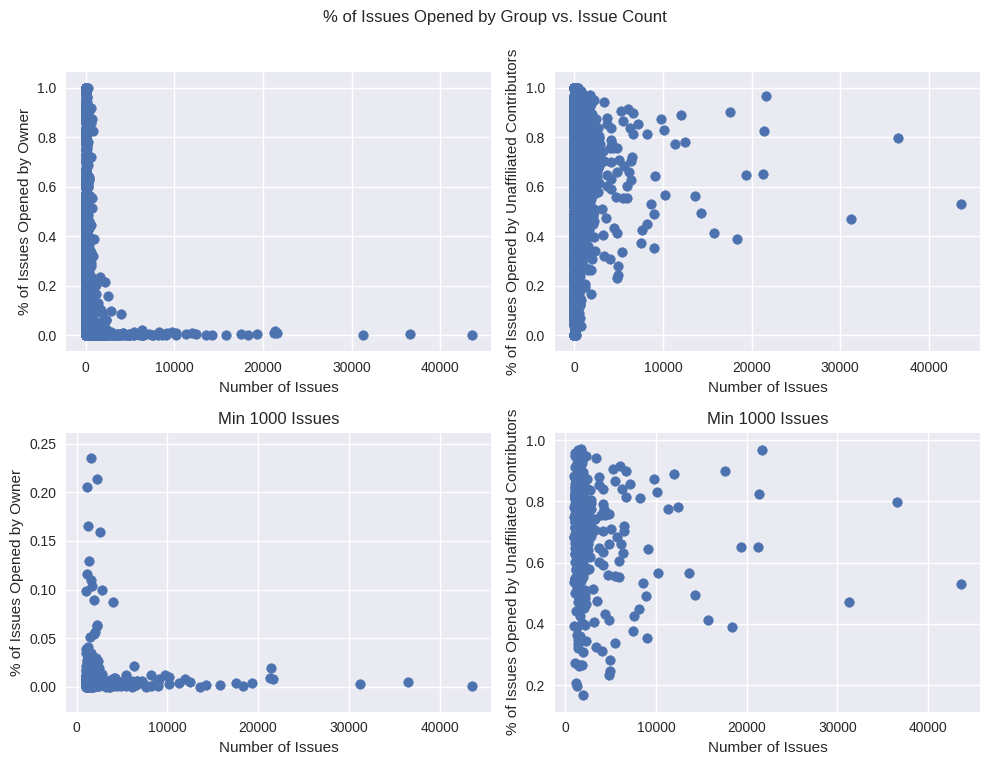

In [60]:
### PLOT EXCLUDES ISSUES THAT WE DO NOT HAVE OPENED/CLOSED dates for
# Initialize layout
fig, ax = plt.subplots(2, 2, figsize = (10, 8))
#plot
ax[0,0].scatter(x = grouped_all_issues['issue_count'], y = grouped_all_issues['opened_owner_mean'])
ax[0,1].scatter(x = grouped_all_issues['issue_count'], y = grouped_all_issues['opened_none_mean'])
ax[1,0].scatter(x = grouped_all_issues.query('issue_count>1000')['issue_count'], 
                y = grouped_all_issues.query('issue_count>1000')['opened_owner_mean'])
ax[1,1].scatter(x = grouped_all_issues.query('issue_count>1000')['issue_count'], 
                y = grouped_all_issues.query('issue_count>1000')['opened_none_mean'])

for i in range(2):
    ax[i, 0].set_ylabel('% of Issues Opened by Owner')
    ax[i, 1].set_ylabel('% of Issues Opened by Unaffiliated Contributors')

    ax[i, 0].set_xlabel('Number of Issues')
    ax[i, 1].set_xlabel('Number of Issues')
    ax[1, i].set_title('Min 1000 Issues')
fig.suptitle("% of Issues Opened by Group vs. Issue Count")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [61]:
tb_ray, all_issues_ray = groupActions(df_issue_clean[df_issue_clean['repo_name'] == 'ray-project/ray'])
tb_ray.round(2)

,NONE,CONTRIBUTOR,MEMBER,COLLABORATOR,OWNER,count
Closing,0.57,0.14,0.25,0.04,0.0,11324
Opening,0.52,0.15,0.30,0.03,0.0,32265


In [62]:
df_issue_clean.to_csv('df_issue_clean_removebad.csv')

In [25]:
grouped_rank.to_csv('grouped_rank_removebad.csv')

## Fix A Problem

In [11]:
df_issue_clean = pd.read_csv('df_issue_clean_removebad.csv', index_col = 0)
grouped_rank = pd.read_csv('grouped_rank_removebad.csv', index_col = 0)

/tmp/user/20506/ipykernel_3184491/2677925804.py:1: DtypeWarning: Columns (11,27,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_issue_clean = pd.read_csv('df_issue_clean_removebad.csv', index_col = 0)


In [12]:
df_issue_clean = df_issue_clean[~df_issue_clean['actor_repo_association'].isna()]

In [13]:
df_issue_clean = df_issue_clean.query('issue_action != "closed" or (actor_repo_association_repaired == "NONE" and issue_user_login==actor_login) or \
    (actor_repo_association_repaired != "NONE")')

# Existence of Hierarchy

Activity is defined as opening, closing and commenting on an issue

In [14]:
explicit_open_keys = df_issue_clean.query('issue_action == "opened"')['key'].unique().tolist()
remaining_issues = df_issue_clean[~df_issue_clean['key'].isin(explicit_open_keys)][['key', 'issue_author_association']].drop_duplicates()['issue_author_association']

In [15]:
def make_generated_activity_base(df_issue_clean):
    rank_identifying_cols = ['actor_login', 'repo_name', 'actor_repo_association_repaired']
    generated_activity_base = pd.concat([
        df_issue_clean[['key', 'issue_author_association_repaired']].drop_duplicates()['issue_author_association_repaired'].value_counts(),
        df_issue_clean.query('issue_action == "closed"')['actor_repo_association_repaired'].value_counts(),
        df_issue_clean.query('issue_action == "closed" and actor_login == issue_user_login')['actor_repo_association_repaired'].value_counts(),
        df_issue_clean.query('issue_action == "closed" and actor_login != issue_user_login')['actor_repo_association_repaired'].value_counts(),
        df_issue_clean.query('type == "IssueCommentEvent"')['actor_repo_association_repaired'].value_counts(),
        df_issue_clean.query('type == "IssueCommentEvent" and actor_login == issue_user_login')['actor_repo_association_repaired'].value_counts(),
        df_issue_clean.query('type == "IssueCommentEvent" and actor_login != issue_user_login')['actor_repo_association_repaired'].value_counts(),
        df_issue_clean[rank_identifying_cols].drop_duplicates()['actor_repo_association_repaired'].value_counts(),
    ], axis = 1).round(2).loc[
        ['NONE', 'CONTRIBUTOR', 'MEMBER', 'COLLABORATOR', 'OWNER']]
    generated_activity_base.columns = ['# of Opened Issues', '# of Closed Issues', '# of Closed Issues (Own Issue)', '# of Closed Issues (Others Issue)', 
                                       '# of Comments', '# of Comments (Own Issue)', '# of Comments (Others Issue)', '# of Individiuals']
    generated_activity_base['Amount of Activity'] = generated_activity_base.apply(
        lambda x: x[['# of Opened Issues', '# of Closed Issues', '# of Comments']].sum(), axis = 1)
    generated_activity_base['Proportion'] = generated_activity_base['Amount of Activity']/generated_activity_base['Amount of Activity'].sum()
    generated_activity_base = generated_activity_base[['Amount of Activity', 'Proportion', '# of Opened Issues', '# of Closed Issues', 
                                                       '# of Closed Issues (Own Issue)', '# of Closed Issues (Others Issue)', 
                                                       '# of Comments', '# of Comments (Own Issue)', '# of Comments (Others Issue)', '# of Individiuals']]
    return generated_activity_base

In [16]:
generated_activity_base = make_generated_activity_base(df_issue_clean)

In [17]:
generated_activity = generated_activity_base.copy()
generated_activity['Activity/Individual'] = generated_activity['Amount of Activity']/generated_activity['# of Individiuals']
for col in ['Opened Issues', 'Closed Issues', 'Closed Issues (Own Issue)',  'Closed Issues (Others Issue)',
            'Comments', 'Comments (Own Issue)', 'Comments (Others Issue)']:
    generated_activity[f'{col}/ Individual'] = generated_activity.apply(
        lambda x: f"{x[f'# of {col}']/x['# of Individiuals']:.2f}\n({100*x[f'# of {col}']/x['Amount of Activity']:.2f}%)", axis = 1)
for col in ['# of Opened Issues', '# of Closed Issues', '# of Closed Issues (Own Issue)', 
            '# of Closed Issues (Others Issue)', '# of Comments', '# of Comments (Own Issue)', 
            '# of Comments (Others Issue)', '# of Individiuals']:
    generated_activity[col] = generated_activity[col].apply(lambda x: f"{x}\n({x/generated_activity[col].sum():.2f})")

In [18]:
pretty_print(generated_activity.round(2))

,Amount of Activity,Proportion,# of Opened Issues,# of Closed Issues,# of Closed Issues (Own Issue),# of Closed Issues (Others Issue),# of Comments,# of Comments (Own Issue),# of Comments (Others Issue),# of Individiuals,Activity/Individual,Opened Issues/ Individual,Closed Issues/ Individual,Closed Issues (Own Issue)/ Individual,Closed Issues (Others Issue)/ Individual,Comments/ Individual,Comments (Own Issue)/ Individual,Comments (Others Issue)/ Individual
NONE,2260563.0,0.52,734937(0.65),8466(0.06),8466(0.28),nan(nan),1517160(0.49),627009(0.65),890151(0.41),536646(0.87),4.21,1.37(32.51%),0.02(0.37%),0.02(0.37%),nan(nan%),2.83(67.11%),1.17(27.74%),1.66(39.38%)
CONTRIBUTOR,934017.0,0.21,209455(0.19),40889(0.31),4525(0.15),36364.0(0.36),683673(0.22),170390(0.18),513283(0.24),42849(0.07),21.80,4.89(22.43%),0.95(4.38%),0.11(0.48%),0.85(3.89%),15.96(73.20%),3.98(18.24%),11.98(54.95%)
MEMBER,465914.0,0.11,85808(0.08),3881(0.03),821(0.03),3060.0(0.03),376225(0.12),85430(0.09),290795(0.14),12971(0.02),35.92,6.62(18.42%),0.30(0.83%),0.06(0.18%),0.24(0.66%),29.01(80.75%),6.59(18.34%),22.42(62.41%)
COLLABORATOR,383901.0,0.09,61082(0.05),7914(0.06),1170(0.04),6744.0(0.07),314905(0.10),56278(0.06),258627(0.12),6019(0.01),63.78,10.15(15.91%),1.31(2.06%),0.19(0.30%),1.12(1.76%),52.32(82.03%),9.35(14.66%),42.97(67.37%)
OWNER,328575.0,0.08,36670(0.03),69556(0.53),15666(0.51),53890.0(0.54),222349(0.07),24590(0.03),197759(0.09),21591(0.03),15.22,1.70(11.16%),3.22(21.17%),0.73(4.77%),2.50(16.40%),10.30(67.67%),1.14(7.48%),9.16(60.19%)


Now, I'm going to weight the individual count by how long they were that rank for. I do this because I know in some weird instances, we see people obtain ranks for very short periods of time. This will allow me to more precisely understand how much activity an individual contributed to. 

In [19]:
all_users = pd.concat([df_issue_clean[['created_at', 'actor_login', 'repo_name']].rename({'actor_login':'user'}, axis = 1),
                       df_issue_clean[['created_at', 'issue_user_login', 'repo_name']].rename({'issue_user_login':'user'}, axis = 1)])
earliest = all_users.sort_values('created_at').drop_duplicates(['user', 'repo_name']).rename({'created_at': 'earliest_date'}, axis = 1)
latest = all_users.sort_values('created_at', ascending = False).drop_duplicates(['user', 'repo_name']).rename({'created_at': 'latest_date'}, axis = 1)
user_dates = pd.merge(latest, earliest, on = ['user', 'repo_name'], how = 'outer')[['user', 'repo_name', 'earliest_date', 'latest_date']]

In [20]:
user_dates['key'] = user_dates['user']+"_"+user_dates['repo_name']
early_dict = user_dates.set_index('key')['earliest_date'].to_dict()
last_dict = user_dates.set_index('key')['latest_date'].to_dict()

In [21]:
from pandas import Timestamp
for col in grouped_rank.columns[4:10]:
    print(col)
    grouped_rank[col] = grouped_rank[col].parallel_apply(lambda x: eval(x, {'datetime': datetime,
                                                                            'Timestamp': Timestamp}))

interval_actor


rank_max_date_actor


rank_min_date_actor


rank_max_date_issue


rank_min_date_issue


interval_issue


In [22]:
def make_time_spent(grouped_rank):
    time_spent = pd.DataFrame(grouped_rank['final_interval'].parallel_apply(
        lambda x: [[ele[0], pd.to_datetime(ele[2])-pd.to_datetime(ele[1])] for ele in x]).explode())
    time_spent['rank'] = time_spent['final_interval'].apply(lambda x: x[0])
    time_spent['time spent'] = time_spent['final_interval'].apply(lambda x: x[1])
    time_spent['Time Spent Seconds'] = time_spent['time spent'].apply(lambda x: x.total_seconds())
    time_spent['Time Spent (Prop.)'] = time_spent['Time Spent Seconds']/time_spent['Time Spent Seconds'].sum()
    time_spent['Time Spent (Worker-Years)'] = time_spent['Time Spent Seconds']/(86400*30*12)

    return time_spent

In [23]:
grouped_rank['key'] = grouped_rank['actor_login']+"_"+grouped_rank['repo_name']
grouped_rank['final_interval'] = grouped_rank.parallel_apply(
    lambda x: [[x['interval_actor'][0][0], early_dict[x['key']], last_dict[x['key']]]] if len(x['interval_actor']) == 1 else 
    [[x['interval_actor'][0][0], early_dict[x['key']], x['interval_actor'][0][2]]] + x['interval_actor'][1:-1] + \
    [[x['interval_actor'][-1][0], x['interval_actor'][-1][1], last_dict[x['key']]]], axis = 1)

time_spent = make_time_spent(grouped_rank)

In [24]:
def make_generated_activity_time(generated_activity_base, time_spent):
    generated_activity_time = pd.concat([generated_activity_base, time_spent.groupby('rank')['Time Spent (Worker-Years)'].sum()], axis = 1)
    generated_activity_time['Activity/Worker-Year'] = generated_activity_time['Amount of Activity']/generated_activity_time['Time Spent (Worker-Years)']
    for col in ['Opened Issues', 'Closed Issues', 'Closed Issues (Own Issue)',  'Closed Issues (Others Issue)',
                'Comments', 'Comments (Own Issue)', 'Comments (Others Issue)']:
        generated_activity_time[f'{col}/Time Spent'] = generated_activity_time.apply(
            lambda x: f"{x[f'# of {col}']/x['Time Spent (Worker-Years)']:.2f}\n ({100*x[f'# of {col}']/x['Amount of Activity']:.2f}%)", axis = 1)
    
    
    for col in ['# of Opened Issues', '# of Closed Issues', '# of Closed Issues (Own Issue)', 
                '# of Closed Issues (Others Issue)', '# of Comments', '# of Comments (Own Issue)', 
                '# of Comments (Others Issue)', '# of Individiuals']:
        generated_activity_time[col] = generated_activity_time[col].apply(lambda x: f"{x:,}\n({x/generated_activity_time[col].sum():.2f})")

    generated_activity_time['Amount of Activity'] = generated_activity_time['Amount of Activity'].apply(lambda x: f"{x:,}")
    generated_activity_time['Proportion'] = generated_activity_time['Proportion'].round(2)

    generated_activity_time['Time Spent (Worker-Years)'] = generated_activity_time['Time Spent (Worker-Years)'].apply(
        lambda x: f"{x:,.2f}\n({x/generated_activity_time['Time Spent (Worker-Years)'].sum():.2f})")
    generated_activity_time['Activity/Worker-Year'] = generated_activity_time['Activity/Worker-Year'].round(2)

    return generated_activity_time

In [25]:
generated_activity_time = make_generated_activity_time(generated_activity_base, time_spent)


main difference between this and a previous analysis is that owners become more involved if you consider the "intensity" of 
someone's actions

ie: how much work someone does within a given time period

I prefer this one because it makes individuals more comparable within a particular time period

**most important findings:**
1) Large Disparity in Activity/Individual - Higher ranked individuals do more things in the same relative time period
2) Individuals progressively spend 
    a) less of their time opening issues (asking questions/flagging problems)
    b) more of their time closing issues (administrative work). In particular its notable how many issues owners close, 
    especially given that they do less things. Owners close A LOT of issues..
3) As individuals rise in rank,
    a) they spend more time commenting on issues, especially other people's issues
    b) they don't spend that much time commenting on their own issues - why is that?

In [26]:
pretty_print(generated_activity_time.round(2))

,Amount of Activity,Proportion,# of Opened Issues,# of Closed Issues,# of Closed Issues (Own Issue),# of Closed Issues (Others Issue),# of Comments,# of Comments (Own Issue),# of Comments (Others Issue),# of Individiuals,Time Spent (Worker-Years),Activity/Worker-Year,Opened Issues/Time Spent,Closed Issues/Time Spent,Closed Issues (Own Issue)/Time Spent,Closed Issues (Others Issue)/Time Spent,Comments/Time Spent,Comments (Own Issue)/Time Spent,Comments (Others Issue)/Time Spent
NONE,"2,260,563.0",0.52,"734,937(0.65)","8,466(0.06)","8,466(0.28)",nan(nan),"1,517,160(0.49)","627,009(0.65)","890,151(0.41)","536,646(0.87)","182,045.50(0.68)",12.42,4.04 (32.51%),0.05 (0.37%),0.05 (0.37%),nan (nan%),8.33 (67.11%),3.44 (27.74%),4.89 (39.38%)
CONTRIBUTOR,"934,017.0",0.21,"209,455(0.19)","40,889(0.31)","4,525(0.15)","36,364.0(0.36)","683,673(0.22)","170,390(0.18)","513,283(0.24)","42,849(0.07)","45,506.53(0.17)",20.52,4.60 (22.43%),0.90 (4.38%),0.10 (0.48%),0.80 (3.89%),15.02 (73.20%),3.74 (18.24%),11.28 (54.95%)
MEMBER,"465,914.0",0.11,"85,808(0.08)","3,881(0.03)",821(0.03),"3,060.0(0.03)","376,225(0.12)","85,430(0.09)","290,795(0.14)","12,971(0.02)","18,195.06(0.07)",25.61,4.72 (18.42%),0.21 (0.83%),0.05 (0.18%),0.17 (0.66%),20.68 (80.75%),4.70 (18.34%),15.98 (62.41%)
COLLABORATOR,"383,901.0",0.09,"61,082(0.05)","7,914(0.06)","1,170(0.04)","6,744.0(0.07)","314,905(0.10)","56,278(0.06)","258,627(0.12)","6,019(0.01)","8,319.34(0.03)",46.15,7.34 (15.91%),0.95 (2.06%),0.14 (0.30%),0.81 (1.76%),37.85 (82.03%),6.76 (14.66%),31.09 (67.37%)
OWNER,"328,575.0",0.08,"36,670(0.03)","69,556(0.53)","15,666(0.51)","53,890.0(0.54)","222,349(0.07)","24,590(0.03)","197,759(0.09)","21,591(0.03)","11,723.34(0.04)",28.03,3.13 (11.16%),5.93 (21.17%),1.34 (4.77%),4.60 (16.40%),18.97 (67.67%),2.10 (7.48%),16.87 (60.19%)


In [27]:
pretty_print(generated_activity_time[['Amount of Activity','Proportion','# of Opened Issues','# of Closed Issues',
                         '# of Closed Issues (Own Issue)','# of Closed Issues (Others Issue)','# of Comments','# of Comments (Own Issue)',
                         '# of Comments (Others Issue)']])

,Amount of Activity,Proportion,# of Opened Issues,# of Closed Issues,# of Closed Issues (Own Issue),# of Closed Issues (Others Issue),# of Comments,# of Comments (Own Issue),# of Comments (Others Issue)
NONE,"2,260,563.0",0.52,"734,937(0.65)","8,466(0.06)","8,466(0.28)",nan(nan),"1,517,160(0.49)","627,009(0.65)","890,151(0.41)"
CONTRIBUTOR,"934,017.0",0.21,"209,455(0.19)","40,889(0.31)","4,525(0.15)","36,364.0(0.36)","683,673(0.22)","170,390(0.18)","513,283(0.24)"
MEMBER,"465,914.0",0.11,"85,808(0.08)","3,881(0.03)",821(0.03),"3,060.0(0.03)","376,225(0.12)","85,430(0.09)","290,795(0.14)"
COLLABORATOR,"383,901.0",0.09,"61,082(0.05)","7,914(0.06)","1,170(0.04)","6,744.0(0.07)","314,905(0.10)","56,278(0.06)","258,627(0.12)"
OWNER,"328,575.0",0.08,"36,670(0.03)","69,556(0.53)","15,666(0.51)","53,890.0(0.54)","222,349(0.07)","24,590(0.03)","197,759(0.09)"


In [28]:
pretty_print(generated_activity_time[['Amount of Activity','Time Spent (Worker-Years)','Activity/Worker-Year','Opened Issues/Time Spent',
                                      'Closed Issues/Time Spent','Closed Issues (Own Issue)/Time Spent','Closed Issues (Others Issue)/Time Spent','Comments/Time Spent',
                                      'Comments (Own Issue)/Time Spent','Comments (Others Issue)/Time Spent']])

,Amount of Activity,Time Spent (Worker-Years),Activity/Worker-Year,Opened Issues/Time Spent,Closed Issues/Time Spent,Closed Issues (Own Issue)/Time Spent,Closed Issues (Others Issue)/Time Spent,Comments/Time Spent,Comments (Own Issue)/Time Spent,Comments (Others Issue)/Time Spent
NONE,"2,260,563.0","182,045.50(0.68)",12.42,4.04 (32.51%),0.05 (0.37%),0.05 (0.37%),nan (nan%),8.33 (67.11%),3.44 (27.74%),4.89 (39.38%)
CONTRIBUTOR,"934,017.0","45,506.53(0.17)",20.52,4.60 (22.43%),0.90 (4.38%),0.10 (0.48%),0.80 (3.89%),15.02 (73.20%),3.74 (18.24%),11.28 (54.95%)
MEMBER,"465,914.0","18,195.06(0.07)",25.61,4.72 (18.42%),0.21 (0.83%),0.05 (0.18%),0.17 (0.66%),20.68 (80.75%),4.70 (18.34%),15.98 (62.41%)
COLLABORATOR,"383,901.0","8,319.34(0.03)",46.15,7.34 (15.91%),0.95 (2.06%),0.14 (0.30%),0.81 (1.76%),37.85 (82.03%),6.76 (14.66%),31.09 (67.37%)
OWNER,"328,575.0","11,723.34(0.04)",28.03,3.13 (11.16%),5.93 (21.17%),1.34 (4.77%),4.60 (16.40%),18.97 (67.67%),2.10 (7.48%),16.87 (60.19%)


In [29]:
# how does it vary by repository size?

In [30]:
repo_contributors = df_issue_clean[['repo_name', 'actor_login']].drop_duplicates()['repo_name'].value_counts()

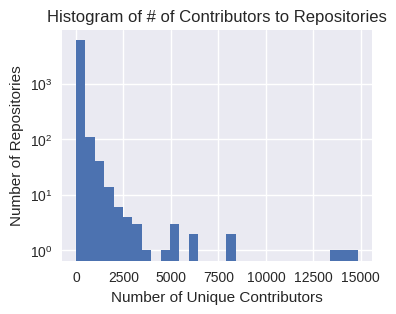

In [31]:
fig, ax = plt.subplots(figsize = (4, 3))
pd.Series(repo_contributors.values).hist(ax = ax, bins = 30)
ax.set_title('Histogram of # of Contributors to Repositories')
ax.set_xlabel('Number of Unique Contributors')
ax.set_ylabel('Number of Repositories')
ax.set_yscale('log')
plt.show()

## Time for More Analysis

The main difference between this and a previous analysis is that owners become more involved if you consider the "intensity" of 
someone's actions (how much work someone does within a given time period). I prefer this one because it makes individuals more comparable within a particular time period

**most important findings:**
1) Large Disparity in Activity/Individual - Higher ranked individuals do more things in the same relative time period
2) Individuals progressively spend
   
    a) less of their time opening issues (asking questions/flagging problems)
   
    b) more of their time closing issues (administrative work). In particular its notable how many issues owners close, 
    especially given that they do less things. Owners close A LOT of issues..
4) As individuals rise in rank,

    a) they spend more time commenting on issues, especially other people's issues

    b) they don't spend that much time commenting on their own issues - why is that?

1) Why do they do more things?

2) 

In [32]:
pretty_print(generated_activity_time.round(2))

,Amount of Activity,Proportion,# of Opened Issues,# of Closed Issues,# of Closed Issues (Own Issue),# of Closed Issues (Others Issue),# of Comments,# of Comments (Own Issue),# of Comments (Others Issue),# of Individiuals,Time Spent (Worker-Years),Activity/Worker-Year,Opened Issues/Time Spent,Closed Issues/Time Spent,Closed Issues (Own Issue)/Time Spent,Closed Issues (Others Issue)/Time Spent,Comments/Time Spent,Comments (Own Issue)/Time Spent,Comments (Others Issue)/Time Spent
NONE,"2,260,563.0",0.52,"734,937(0.65)","8,466(0.06)","8,466(0.28)",nan(nan),"1,517,160(0.49)","627,009(0.65)","890,151(0.41)","536,646(0.87)","182,045.50(0.68)",12.42,4.04 (32.51%),0.05 (0.37%),0.05 (0.37%),nan (nan%),8.33 (67.11%),3.44 (27.74%),4.89 (39.38%)
CONTRIBUTOR,"934,017.0",0.21,"209,455(0.19)","40,889(0.31)","4,525(0.15)","36,364.0(0.36)","683,673(0.22)","170,390(0.18)","513,283(0.24)","42,849(0.07)","45,506.53(0.17)",20.52,4.60 (22.43%),0.90 (4.38%),0.10 (0.48%),0.80 (3.89%),15.02 (73.20%),3.74 (18.24%),11.28 (54.95%)
MEMBER,"465,914.0",0.11,"85,808(0.08)","3,881(0.03)",821(0.03),"3,060.0(0.03)","376,225(0.12)","85,430(0.09)","290,795(0.14)","12,971(0.02)","18,195.06(0.07)",25.61,4.72 (18.42%),0.21 (0.83%),0.05 (0.18%),0.17 (0.66%),20.68 (80.75%),4.70 (18.34%),15.98 (62.41%)
COLLABORATOR,"383,901.0",0.09,"61,082(0.05)","7,914(0.06)","1,170(0.04)","6,744.0(0.07)","314,905(0.10)","56,278(0.06)","258,627(0.12)","6,019(0.01)","8,319.34(0.03)",46.15,7.34 (15.91%),0.95 (2.06%),0.14 (0.30%),0.81 (1.76%),37.85 (82.03%),6.76 (14.66%),31.09 (67.37%)
OWNER,"328,575.0",0.08,"36,670(0.03)","69,556(0.53)","15,666(0.51)","53,890.0(0.54)","222,349(0.07)","24,590(0.03)","197,759(0.09)","21,591(0.03)","11,723.34(0.04)",28.03,3.13 (11.16%),5.93 (21.17%),1.34 (4.77%),4.60 (16.40%),18.97 (67.67%),2.10 (7.48%),16.87 (60.19%)


In [33]:
organization_list = df_issue_clean['org_login'].dropna().unique()

In [34]:
watch_lst = glob.glob('data/github_clean/github_data_pre_18/watchEvent*')
watch_lst.extend(glob.glob('data/github_clean/filtered_github_data/watchEvent*'))
watch_data = pd.concat([pd.read_csv(file, usecols = ['repo_name'], engine = 'pyarrow') for file in watch_lst])
watch_data = watch_data.value_counts()

In [35]:
fork_lst = glob.glob('data/github_clean/github_data_pre_18/forkEvent*')
fork_lst.extend(glob.glob('data/github_clean/filtered_github_data/forkEvent*'))
fork_data = pd.concat([pd.read_csv(file, usecols = ['repo_name'], engine = 'pyarrow') for file in fork_lst])
fork_data = fork_data.value_counts()

In [36]:
def calculateTimeSpent(grouped_rank):
    time_spent = pd.DataFrame(grouped_rank['final_interval'].parallel_apply(
        lambda x: [[ele[0], pd.to_datetime(ele[2])-pd.to_datetime(ele[1])] for ele in x]).explode())
    time_spent['rank'] = time_spent['final_interval'].apply(lambda x: x[0])
    time_spent['time spent'] = time_spent['final_interval'].apply(lambda x: x[1])
    time_spent['Time Spent Seconds'] = time_spent['time spent'].apply(lambda x: x.total_seconds())
    time_spent['Time Spent (Prop.)'] = time_spent['Time Spent Seconds']/time_spent['Time Spent Seconds'].sum()
    time_spent['Time Spent (Worker-Years)'] = time_spent['Time Spent Seconds']/(86400*30*12)
    return time_spent

In [37]:
time_spent_org = calculateTimeSpent(grouped_rank[grouped_rank['repo_name'].apply(lambda x: x.split("/")[0] in organization_list)])
time_spent_noorg = calculateTimeSpent(grouped_rank[~grouped_rank['repo_name'].apply(lambda x: x.split("/")[0] in organization_list)])
time_spent_many_contributor = calculateTimeSpent(grouped_rank[grouped_rank['repo_name'].isin(repo_contributors.head(300).index)])
time_spent_no_many = calculateTimeSpent(grouped_rank[~grouped_rank['repo_name'].isin(repo_contributors.head(300).index)])
time_spent_most_activity = calculateTimeSpent(grouped_rank[grouped_rank['repo_name'].isin(
    df_issue_clean['repo_name'].value_counts().head(300).index)])
time_spent_not_most = calculateTimeSpent(grouped_rank[~grouped_rank['repo_name'].isin(
    df_issue_clean['repo_name'].value_counts().head(300).index)])
time_spent_most_watch = calculateTimeSpent(grouped_rank[grouped_rank['repo_name'].isin(
    watch_data.reset_index()['repo_name'].head(300).tolist())])
time_spent_not_watch = calculateTimeSpent(grouped_rank[~grouped_rank['repo_name'].isin(
    watch_data.reset_index()['repo_name'].head(300).tolist())])
time_spent_most_fork = calculateTimeSpent(grouped_rank[grouped_rank['repo_name'].isin(
    fork_data.reset_index()['repo_name'].head(300).tolist())])
time_spent_not_fork = calculateTimeSpent(grouped_rank[~grouped_rank['repo_name'].isin(
    fork_data.reset_index()['repo_name'].head(300).tolist())])

In [38]:
hierarchy_dist_most = pd.concat([
    time_spent_org.groupby('rank')['Time Spent (Worker-Years)'].sum().rename('Organization'),
    time_spent_many_contributor.groupby('rank')['Time Spent (Worker-Years)'].sum().rename('Top 300 (repos) Most Contributors'),
    time_spent_most_activity.groupby('rank')['Time Spent (Worker-Years)'].sum().rename('Top 300 (repos) Most Activity'),
    time_spent_most_watch.groupby('rank')['Time Spent (Worker-Years)'].sum().rename('Top 300 (repos) Most Watches'),
    time_spent_most_fork.groupby('rank')['Time Spent (Worker-Years)'].sum().rename('Top 300 (repos) Most Forks'),
], axis = 1)
hierarchy_dist_less = pd.concat([
    time_spent_noorg.groupby('rank')['Time Spent (Worker-Years)'].sum().rename('Not Organization'),
    time_spent_no_many.groupby('rank')['Time Spent (Worker-Years)'].sum().rename('Not Top 300 (repos) Most Contributors'),
    time_spent_not_most.groupby('rank')['Time Spent (Worker-Years)'].sum().rename('Not Top 300 (repos) Most Activity'),
    time_spent_not_watch.groupby('rank')['Time Spent (Worker-Years)'].sum().rename('Not Top 300 (repos) Most Watches'),
    time_spent_not_fork.groupby('rank')['Time Spent (Worker-Years)'].sum().rename('Not Top 300 (repos) Most Forks'),
], axis = 1)

for col in hierarchy_dist_most.columns:
    hierarchy_dist_most[col] = hierarchy_dist_most[col].apply(lambda x: f"{x:.0f}\n({x/hierarchy_dist_most[col].sum():.2f})")
for col in hierarchy_dist_less.columns:
    hierarchy_dist_less[col] = hierarchy_dist_less[col].apply(lambda x: f"{x:.0f}\n({x/hierarchy_dist_less[col].sum():.2f})")

hierarchy_dist_most.columns.name = 'Time Spent (Worker-Years)'
hierarchy_dist_less.columns.name = 'Time Spent (Worker-Years)'
pretty_print(hierarchy_dist_most.loc[['NONE', 'CONTRIBUTOR', 'MEMBER','COLLABORATOR', 'OWNER']])

Time Spent (Worker-Years),Organization,Top 300 (repos) Most Contributors,Top 300 (repos) Most Activity,Top 300 (repos) Most Watches,Top 300 (repos) Most Forks
rank,,,,,
NONE,120842(0.68),106181(0.81),97383(0.78),88696(0.81),93183(0.81)
CONTRIBUTOR,31971(0.18),16805(0.13),18334(0.15),13819(0.13),14786(0.13)
MEMBER,18195(0.10),5980(0.05),6817(0.05),4765(0.04),5212(0.05)
COLLABORATOR,5480(0.03),1843(0.01),2644(0.02),1655(0.02),1784(0.02)
OWNER,35(0.00),319(0.00),248(0.00),516(0.00),483(0.00)


In [39]:
pretty_print(hierarchy_dist_less.loc[['NONE', 'CONTRIBUTOR', 'MEMBER','COLLABORATOR', 'OWNER']])

Time Spent (Worker-Years),Not Organization,Not Top 300 (repos) Most Contributors,Not Top 300 (repos) Most Activity,Not Top 300 (repos) Most Watches,Not Top 300 (repos) Most Forks
rank,,,,,
NONE,61203(0.69),75865(0.56),84662(0.60),93349(0.60),88863(0.59)
CONTRIBUTOR,13536(0.15),28701(0.21),27172(0.19),31687(0.20),30720(0.20)
MEMBER,nan(nan),12215(0.09),11378(0.08),13430(0.09),12983(0.09)
COLLABORATOR,2840(0.03),6476(0.05),5676(0.04),6665(0.04),6535(0.04)
OWNER,11688(0.13),11405(0.08),11475(0.08),11207(0.07),11241(0.07)


In [40]:
top300_contri_grouped_rank = grouped_rank[grouped_rank['repo_name'].isin(repo_contributors.head(300).index)]
top300_contri_df_issue_clean = df_issue_clean[df_issue_clean['repo_name'].isin(repo_contributors.head(300).index)]
nottop300_contri_grouped_rank = grouped_rank[~grouped_rank['repo_name'].isin(repo_contributors.head(300).index)]
nottop300_contri_df_issue_clean = df_issue_clean[~df_issue_clean['repo_name'].isin(repo_contributors.head(300).index)]

In [41]:
top300_contri_time_spent = make_time_spent(top300_contri_grouped_rank)
top300_contri_generated_activity_base = make_generated_activity_base(top300_contri_df_issue_clean)
top300_contri_generated_activity_time = make_generated_activity_time(top300_contri_generated_activity_base, top300_contri_time_spent)

In [42]:
nottop300_contri_time_spent = make_time_spent(nottop300_contri_grouped_rank)
nottop300_contri_generated_activity_base = make_generated_activity_base(nottop300_contri_df_issue_clean)
nottop300_contri_generated_activity_time = make_generated_activity_time(nottop300_contri_generated_activity_base, nottop300_contri_time_spent)

In [43]:
top300_contri_generated_activity_time.columns.name = 'Top 300 Repositories, by Contributor Count'
pretty_print(top300_contri_generated_activity_time[['Amount of Activity','Proportion','# of Opened Issues','# of Closed Issues',
                         '# of Closed Issues (Own Issue)','# of Closed Issues (Others Issue)','# of Comments','# of Comments (Own Issue)',
                         '# of Comments (Others Issue)']])

"Top 300 Repositories, by Contributor Count",Amount of Activity,Proportion,# of Opened Issues,# of Closed Issues,# of Closed Issues (Own Issue),# of Closed Issues (Others Issue),# of Comments,# of Comments (Own Issue),# of Comments (Others Issue)
NONE,"1,225,733.0",0.54,"371,030(0.69)","4,208(0.10)","4,208(0.52)",nan(nan),"850,495(0.51)","327,956(0.68)","522,539(0.44)"
CONTRIBUTOR,"437,577.0",0.19,"86,154(0.16)","17,327(0.41)","1,332(0.16)","15,995.0(0.46)","334,096(0.20)","72,731(0.15)","261,365(0.22)"
MEMBER,"308,986.0",0.14,"52,344(0.10)","2,475(0.06)",410(0.05),"2,065.0(0.06)","254,167(0.15)","57,057(0.12)","197,110(0.16)"
COLLABORATOR,"223,166.0",0.10,"24,276(0.04)","4,533(0.11)",426(0.05),"4,107.0(0.12)","194,357(0.12)","22,959(0.05)","171,398(0.14)"
OWNER,"68,428.0",0.03,"6,460(0.01)","14,166(0.33)","1,735(0.21)","12,431.0(0.36)","47,802(0.03)","3,164(0.01)","44,638(0.04)"


In [150]:
nottop300_contri_generated_activity_time.columns.name = 'All Repositories except Top 300 by Contributor Count'
pretty_print(nottop300_contri_generated_activity_time[['Amount of Activity','Proportion','# of Opened Issues','# of Closed Issues',
                         '# of Closed Issues (Own Issue)','# of Closed Issues (Others Issue)','# of Comments','# of Comments (Own Issue)',
                         '# of Comments (Others Issue)']]) 

All Repositories except Top 300 by Contributor Count,Amount of Activity,Proportion,# of Opened Issues,# of Closed Issues,# of Closed Issues (Own Issue),# of Closed Issues (Others Issue),# of Comments,# of Comments (Own Issue),# of Comments (Others Issue)
NONE,"1,034,873.0",0.49,"363,950(0.62)","4,258(0.05)","4,258(0.19)",nan(nan),"666,665(0.47)","299,053(0.62)","367,612(0.39)"
CONTRIBUTOR,"496,475.0",0.24,"123,336(0.21)","23,562(0.27)","3,193(0.14)","20,369.0(0.31)","349,577(0.24)","97,659(0.20)","251,918(0.26)"
MEMBER,"156,928.0",0.07,"33,464(0.06)","1,406(0.02)",411(0.02),995.0(0.02),"122,058(0.09)","28,373(0.06)","93,685(0.10)"
COLLABORATOR,"160,735.0",0.08,"36,806(0.06)","3,381(0.04)",744(0.03),"2,637.0(0.04)","120,548(0.08)","33,319(0.07)","87,229(0.09)"
OWNER,"260,147.0",0.12,"30,210(0.05)","55,390(0.63)","13,931(0.62)","41,459.0(0.63)","174,547(0.12)","21,426(0.04)","153,121(0.16)"


In [159]:
print(top300_contri_df_issue_clean.shape[0]/top300_contri_df_issue_clean['key'].unique().shape[0], top300_contri_df_issue_clean['key'].unique().shape[0])
print(nottop300_contri_df_issue_clean.shape[0]/nottop300_contri_df_issue_clean['key'].unique().shape[0], nottop300_contri_df_issue_clean['key'].unique().shape[0])

3.8280183985089686 526347
3.0017242245174685 597370


In [44]:
pretty_print(top300_contri_generated_activity_time[['Amount of Activity','Time Spent (Worker-Years)','Activity/Worker-Year','Opened Issues/Time Spent',
                                      'Closed Issues/Time Spent','Closed Issues (Own Issue)/Time Spent','Closed Issues (Others Issue)/Time Spent','Comments/Time Spent',
                                      'Comments (Own Issue)/Time Spent','Comments (Others Issue)/Time Spent']])

"Top 300 Repositories, by Contributor Count",Amount of Activity,Time Spent (Worker-Years),Activity/Worker-Year,Opened Issues/Time Spent,Closed Issues/Time Spent,Closed Issues (Own Issue)/Time Spent,Closed Issues (Others Issue)/Time Spent,Comments/Time Spent,Comments (Own Issue)/Time Spent,Comments (Others Issue)/Time Spent
NONE,"1,225,733.0","106,180.52(0.81)",11.54,3.49 (30.27%),0.04 (0.34%),0.04 (0.34%),nan (nan%),8.01 (69.39%),3.09 (26.76%),4.92 (42.63%)
CONTRIBUTOR,"437,577.0","16,805.11(0.13)",26.04,5.13 (19.69%),1.03 (3.96%),0.08 (0.30%),0.95 (3.66%),19.88 (76.35%),4.33 (16.62%),15.55 (59.73%)
MEMBER,"308,986.0","5,980.16(0.05)",51.67,8.75 (16.94%),0.41 (0.80%),0.07 (0.13%),0.35 (0.67%),42.50 (82.26%),9.54 (18.47%),32.96 (63.79%)
COLLABORATOR,"223,166.0","1,843.19(0.01)",121.08,13.17 (10.88%),2.46 (2.03%),0.23 (0.19%),2.23 (1.84%),105.45 (87.09%),12.46 (10.29%),92.99 (76.80%)
OWNER,"68,428.0",318.75(0.00),214.68,20.27 (9.44%),44.44 (20.70%),5.44 (2.54%),39.00 (18.17%),149.97 (69.86%),9.93 (4.62%),140.04 (65.23%)


In [45]:
pretty_print(nottop300_contri_generated_activity_time[['Amount of Activity','Time Spent (Worker-Years)','Activity/Worker-Year','Opened Issues/Time Spent',
                                      'Closed Issues/Time Spent','Closed Issues (Own Issue)/Time Spent','Closed Issues (Others Issue)/Time Spent','Comments/Time Spent',
                                      'Comments (Own Issue)/Time Spent','Comments (Others Issue)/Time Spent']])

,Amount of Activity,Time Spent (Worker-Years),Activity/Worker-Year,Opened Issues/Time Spent,Closed Issues/Time Spent,Closed Issues (Own Issue)/Time Spent,Closed Issues (Others Issue)/Time Spent,Comments/Time Spent,Comments (Own Issue)/Time Spent,Comments (Others Issue)/Time Spent
NONE,"1,034,873.0","75,864.98(0.56)",13.64,4.80 (35.17%),0.06 (0.41%),0.06 (0.41%),nan (nan%),8.79 (64.42%),3.94 (28.90%),4.85 (35.52%)
CONTRIBUTOR,"496,475.0","28,701.43(0.21)",17.30,4.30 (24.84%),0.82 (4.75%),0.11 (0.64%),0.71 (4.10%),12.18 (70.41%),3.40 (19.67%),8.78 (50.74%)
MEMBER,"156,928.0","12,214.90(0.09)",12.85,2.74 (21.32%),0.12 (0.90%),0.03 (0.26%),0.08 (0.63%),9.99 (77.78%),2.32 (18.08%),7.67 (59.70%)
COLLABORATOR,"160,735.0","6,476.15(0.05)",24.82,5.68 (22.90%),0.52 (2.10%),0.11 (0.46%),0.41 (1.64%),18.61 (75.00%),5.14 (20.73%),13.47 (54.27%)
OWNER,"260,147.0","11,404.59(0.08)",22.81,2.65 (11.61%),4.86 (21.29%),1.22 (5.36%),3.64 (15.94%),15.30 (67.10%),1.88 (8.24%),13.43 (58.86%)


## Analyzing the Lifetime of an Issue

In [9]:
non_author_comments = df_issue_clean[(df_issue_clean['type'] == 'IssueCommentEvent') & (df_issue_clean['actor_login'] != df_issue_clean['issue_user_login'])]

In [27]:
num_contributors = df_issue_clean[['key', 'actor_login']].drop_duplicates()
print(f"{num_contributors.shape[0]/df_issue_clean['key'].unique().shape[0]:.2f} contributors to each issue on average")

2.08 contributors to each issue on average


In [20]:
contributors_per_issue = num_contributors.groupby('key')['actor_login'].count()

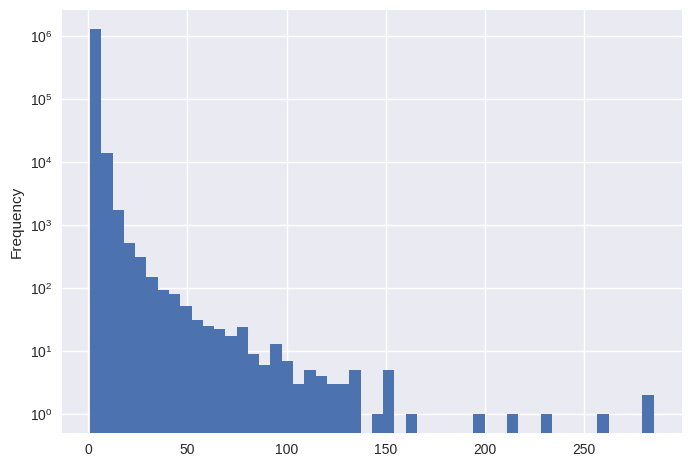

In [26]:
fig, ax = plt.subplots()
contributors_per_issue.plot(kind = 'hist', ax = ax, bins = 50)
ax.set_yscale('log')
plt.show()

In [29]:
first_nonauthor_comment = non_author_comments.sort_values('created_at').drop_duplicates(['key'])

In [42]:
second_nonauthor_comment = non_author_comments[~non_author_comments.index.isin(first_nonauthor_comment.index)].sort_values(
    'created_at').drop_duplicates(['key'])

In [53]:
# second commenter normally same as first commenter
# surprisingly a lot of NONEs reply to NONE opened issues (discussion involving unaffiliateds, and then contributors)
# mostly NONEs that respond to OWNER issues (interesting...very unhierarchical)
# otherwise OWNERs rarely respond to issues
# CONTRIBUTOR -> most likely is fellow contributor, then NONE (how to explain?) then MEMBER and then COLLABORATOR
# COLLABORATOR -> most likely is COLLABORATOR, then NONE, then CONTRIBUTOR then MEMBER
# MEMBER IS WEIRD
# similarly MEMBER -> most likely is MEMBER, then NONE, then CONTRIBUTOR, then COLLABORATOR
# i mean general vibe is similar RANK, and then decreasing chance of lower -> higher rank individuals


commentor_author = pd.concat([first_nonauthor_comment.groupby('issue_author_association_repaired')[
                              'actor_repo_association_repaired'].value_counts(),
                              first_nonauthor_comment.groupby('issue_author_association_repaired')[
                              'actor_repo_association_repaired'].value_counts(normalize = True),
                              second_nonauthor_comment.groupby('issue_author_association_repaired')[
                              'actor_repo_association_repaired'].value_counts(),
                              second_nonauthor_comment.groupby('issue_author_association_repaired')[
                              'actor_repo_association_repaired'].value_counts(normalize = True),
          ], axis = 1).loc[[
    'NONE', 'CONTRIBUTOR', 'MEMBER', 'COLLABORATOR', 'OWNER']]
commentor_author = commentor_author.reset_index()
#commentor_author.columns = ['Author Rank', 'Replier Rank', 'First Replier (Count)', 'Second Replier']
commentor_author.round(2)

,issue_author_association_repaired,actor_repo_association_repaired,count,proportion,count,proportion
0,NONE,NONE,283016,0.47,158893,0.48
1,NONE,CONTRIBUTOR,144774,0.24,75255,0.23
2,NONE,MEMBER,62234,0.10,36586,0.11
3,NONE,COLLABORATOR,59120,0.10,33006,0.10
4,NONE,OWNER,51159,0.09,25587,0.08
5,CONTRIBUTOR,CONTRIBUTOR,46973,0.36,19434,0.33
6,CONTRIBUTOR,NONE,36379,0.28,18612,0.32
7,CONTRIBUTOR,MEMBER,22500,0.17,9527,0.16
8,CONTRIBUTOR,COLLABORATOR,22306,0.17,8772,0.15
9,CONTRIBUTOR,OWNER,3731,0.03,1951,0.03


In [ ]:
# how many different individuals are involved in commenting on an issue? how many commenters are there? How are the two related?
# how often is the closer one of the commenters?
# when do you see the first commenter (second person) arrive? third person? what is their rank
# 

In [10]:
non_author_comments['earliest_nonauthor_comment_date'] = non_author_comments.groupby(['key', 'created_at'])['created_at'].transform('min')


KeyboardInterrupt



In [ ]:
non_author_comments[non_author_comments['earliest_nonauthor_comment_date'] == non_author_comments['created_at']].groupby(
    'issue_author_association_repaired')['actor_repo_association_repaired'].value_counts()

In [ ]:
## whose opening issues
## whose commenting
## whose closing issues

df_issue_clean

In [ ]:
break

In [ ]:
# read prs

add smt about PRs (linked PRs = issue that is PR review + PRs I connected)

# now have to dig into PRs....

# who works on the PR (code)
# who works on the PR (commenting on PR review)
# who works on the issue itself (commenting)

# who reviews the PR request

# closed date
# comment info 